<a href="https://colab.research.google.com/github/rll/deepul/blob/master/demos/lecture1_autoregressive_models_demos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Getting Started
Go to **Runtime -> Change runtime type** and make sure **Hardward accelerator** is set to **GPU**

In [ ]:
!if [ -d cs294-158-autoreg-master ]; then rm -Rf cs294-158-autoreg-master; fi
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=17npUPcK1eXV9YtMMODwQEIvLkUgq8m2m' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=17npUPcK1eXV9YtMMODwQEIvLkUgq8m2m" -O cs294-158-autoreg-master.zip && rm -rf /tmp/cookies.txt
!unzip -qq cs294-158-autoreg-master.zip
!rm cs294-158-autoreg-master.zip
!pip install cs294-158-autoreg-master/

In [ ]:
!if [ -d pretrained_models ]; then rm -Rf pretrained_models; fi
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1CuFbTWshUfmU3F4bc2SODxzMm1vFU4hC' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1CuFbTWshUfmU3F4bc2SODxzMm1vFU4hC" -O pretrained_models.zip && rm -rf /tmp/cookies.txt
!unzip -qq pretrained_models.zip
!rm pretrained_models.zip

In [1]:
def load_data():
    from torchvision import transforms
    from torchvision.datasets import MNIST
    import torch.utils.data as data

    transform = transforms.Compose([
        transforms.ToTensor(),
        lambda x: (x > 0.5).float()
    ])
    train_dset = MNIST('data', transform=transform, train=True, download=True)
    test_dset = MNIST('data', transform=transform, train=False, download=True)

    train_loader = data.DataLoader(train_dset, batch_size=128, shuffle=True,
                                   pin_memory=True, num_workers=2)
    test_loader = data.DataLoader(test_dset, batch_size=128, shuffle=True,
                                  pin_memory=True, num_workers=2)

    return train_loader, test_loader
load_data()
print('Pre-downloaded dataset')

import warnings
warnings.filterwarnings('ignore')

Pre-downloaded dataset


#Demo 1: Fitting a Simple 1D Discrete Distribution
In this demo, we design a 1D dataset with intentially missing data for certain values, and compare the performance of simple histogram fitting versus parameterizing our distribution as a mixture of logistics. 

In [48]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

from deepul_helper.data import load_demo_1
from deepul_helper.visualize import plot_hist, plot_train_curves

## Initializing Hyperparameters and Visualizing Dataset

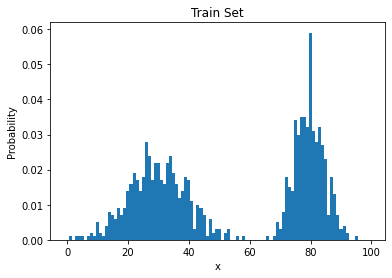

In [3]:
SEED = 1
np.random.seed(SEED)
torch.manual_seed(SEED)

n_train, d = 1000, 100
loader_args = dict(batch_size=128, shuffle=True)
train_loader = load_demo_1(n_train, 1, d, loader_args, visualize=True, train_only=True)

## ASD: 1D Data
Here the data-set is a series of numbers. Each number is a scalar value in [0,d]. Hence the histogram is a 1D plot upto d value. p(x) here is the normalized frequecy of occurance of the values.

## Training Code
We optimize our models using gradient descent and minimize negative log-likelihood.

In [4]:
def train(model, train_loader, optimizer):
    model.train()
    for x in train_loader:
        loss = model.nll(x)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


def eval_loss(model, data_loader):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for x in data_loader:
            loss = model.nll(x)
            total_loss += loss * x.shape[0]
        avg_loss = total_loss / len(data_loader.dataset)
    return avg_loss.item()


def train_epochs(model, train_loader, test_loader, train_args):
    epochs, lr = train_args['epochs'], train_args['lr']
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses, test_losses = [], []
    for epoch in range(epochs):
        model.train()

        train(model, train_loader, optimizer)
        train_loss = eval_loss(model, train_loader)
        train_losses.append(train_loss)

        if test_loader is not None:
            test_loss = eval_loss(model, test_loader)
            test_losses.append(test_loss)

        if epoch in [0, 2, 10, 50, 99]:
            plot_hist(train_loader.dataset.array, bins=d,
                      title=f'Epoch {epoch}', density=model.get_density())
    if test_loader is not None:
      print('Test Loss', test_loss)

    plot_train_curves(epochs, train_losses, test_losses, title='Training Curve')

## Model 1: Histogram

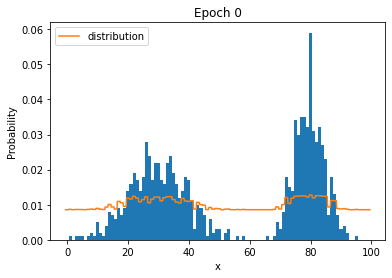

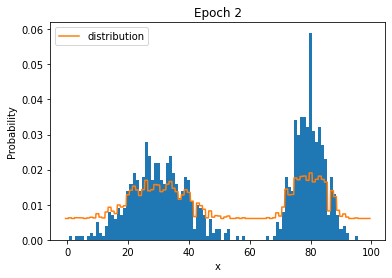

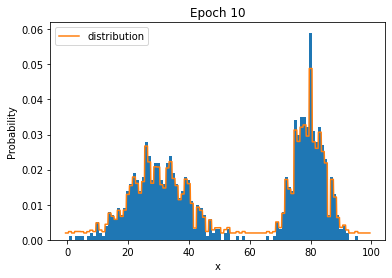

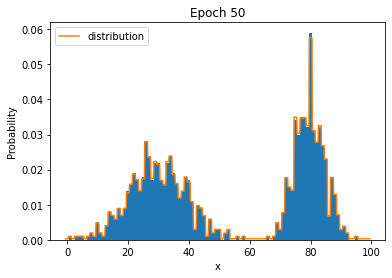

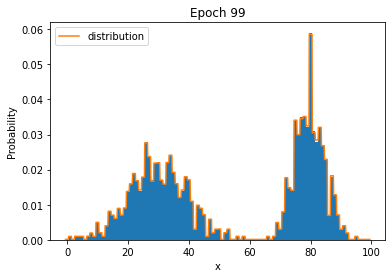

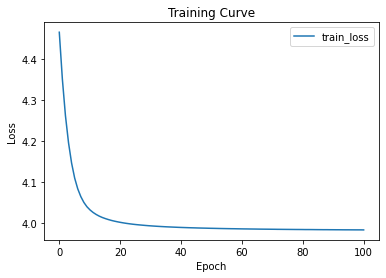

In [10]:
class Histogram(nn.Module):
    def __init__(self, d):
        super().__init__()
        self.d = d
        self.logits = nn.Parameter(torch.zeros(d), requires_grad=True)

    # Compute loss as negative log-likelihood
    def nll(self, x):
        nll = nn.NLLLoss()
        logsoftmax = nn.LogSoftmax()
        logits = logsoftmax(self.logits.unsqueeze(0).repeat(x.shape[0], 1))
        return nll(logits,x.long()) 
        #return F.cross_entropy(logits, x.long())

    def get_density(self):
        x = np.linspace(-0.5, self.d - 0.5, 1000)
        with torch.no_grad():
            y = F.softmax(self.logits, dim=0).unsqueeze(1).repeat(1, 1000 // self.d).view(-1).numpy()
        #print (x.shape,y.shape)
        return x, y

hist = Histogram(d)
train_epochs(hist, train_loader, None, dict(epochs=100, lr=2.5e-2))

## Model 2: Discretized Mixture of Logistics

## ASD: Read more about Logistics fucntion and its use here
Here logistics is used to model the probablity density function. Read more about it at https://arxiv.org/pdf/1701.05517.pdf , http://bjlkeng.github.io/posts/pixelcnn/"

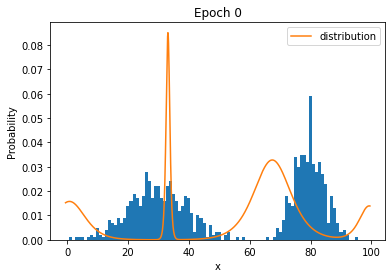

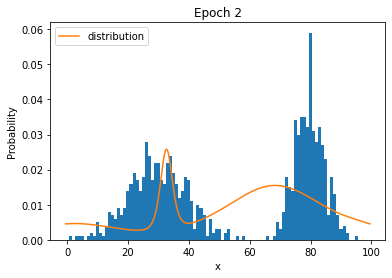

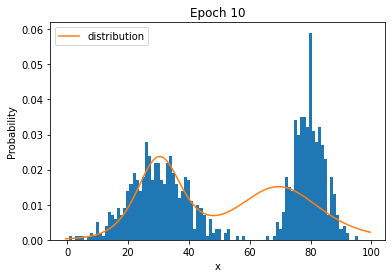

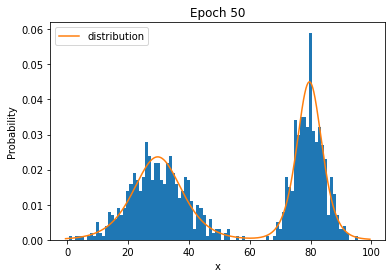

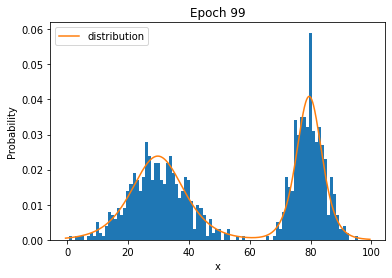

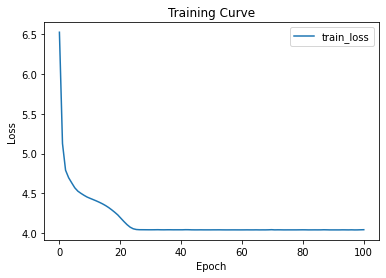

In [11]:
class MixtureOfLogistics(nn.Module):
    def __init__(self, d, n_mix=4):
        super().__init__()
        self.d = d
        self.n_mix = n_mix

        self.logits = nn.Parameter(torch.zeros(n_mix), requires_grad=True)
        self.means = nn.Parameter(torch.arange(n_mix).float() / (n_mix - 1) * d, requires_grad=True)
        self.log_scales = nn.Parameter(torch.randn(n_mix), requires_grad=True)

    def nll(self, x):
        x = x.unsqueeze(1).repeat(1, self.n_mix) # b x n_mix
        means, log_scales = self.means.unsqueeze(0), self.log_scales.unsqueeze(0) # 1 x n_mix
        inv_scales = torch.exp(-log_scales)

        plus_in = inv_scales * (x + 0.5 - means)
        min_in = inv_scales * (x - 0.5 - means)

        cdf_plus = torch.sigmoid(plus_in) # CDF of logistics at x + 0.5
        cdf_min = torch.sigmoid(min_in) # CDF of logistics at x - 0.5

        cdf_delta = cdf_plus - cdf_min # probability of x in bin [x - 0.5, x + 0.5]
        log_cdf_delta = torch.log(torch.clamp(cdf_delta, min=1e-12))
        log_cdf_plus = torch.sigmoid(inv_scales * (0.5 - means))
        log_cdf_min = torch.sigmoid(inv_scales * (d - 1.5 - means))

        x_log_probs = torch.where(x < 0.001, log_cdf_plus,
                                  torch.where(x > d - 1 - 1e-3,
                                              log_cdf_min, log_cdf_delta))
        pi_log_probs = F.log_softmax(self.logits, dim=0).unsqueeze(0)
        log_probs = x_log_probs + pi_log_probs
        return -torch.mean(torch.logsumexp(log_probs, dim=1))

    def get_density(self):
        x = np.linspace(-0.5, self.d - 1 + 0.5, 1000)

        with torch.no_grad():
            x_pt = torch.FloatTensor(x).unsqueeze(1)
            means, log_scales = self.means.unsqueeze(0), self.log_scales.unsqueeze(0)
            pi_log_probs = F.log_softmax(self.logits, dim=0).unsqueeze(0)

            # Calculate pdf of logistic distributions and weight them
            # according to learned mixture probabilities
            x_in = (x_pt - means) * torch.exp(-log_scales)
            log_pdf = x_in - log_scales - 2 * F.softplus(x_in)
            log_pdf = log_pdf + pi_log_probs
            log_pdf = torch.logsumexp(log_pdf, dim=1)
            pdf = log_pdf.exp()

        return x, pdf.numpy()

discretized = MixtureOfLogistics(d, n_mix=4)
train_epochs(discretized, train_loader, None, dict(epochs=100, lr=1e-1))

## Comparing with Test Data (with missing data)


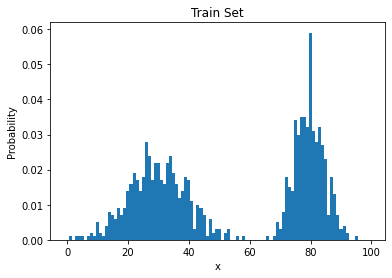

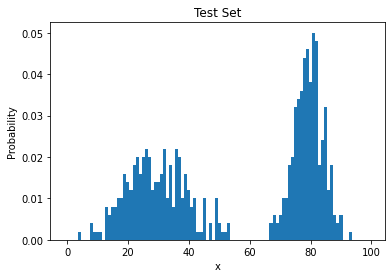

In [12]:
n_train, n_test, d = 1000, 500, 100
loader_args = dict(batch_size=128, shuffle=True)
train_loader, test_loader = load_demo_1(n_train, n_test, d, loader_args, visualize=True)

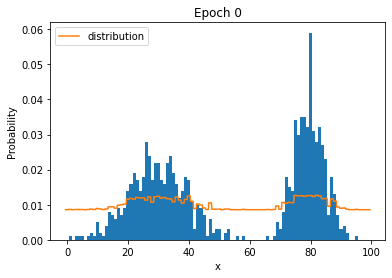

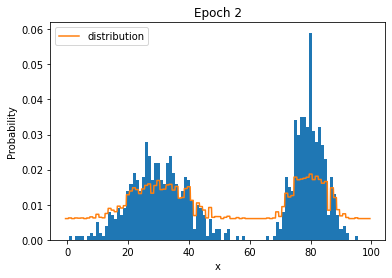

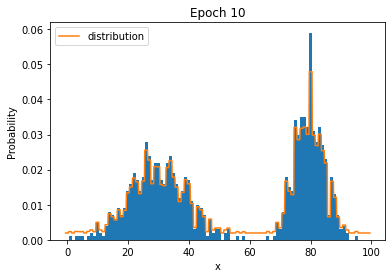

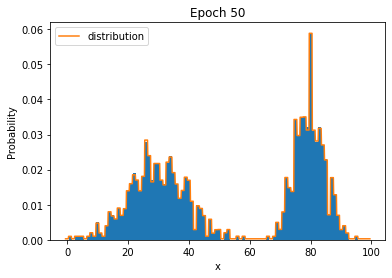

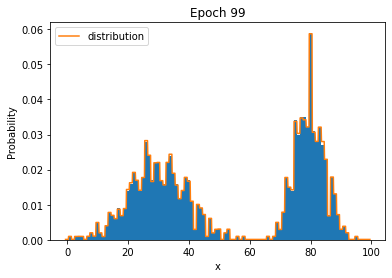

Test Loss 4.0615386962890625


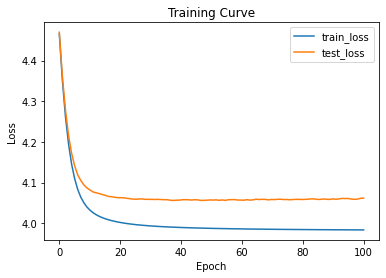

In [13]:
hist = Histogram(d)
train_epochs(hist, train_loader, test_loader, dict(epochs=100, lr=2.5e-2))

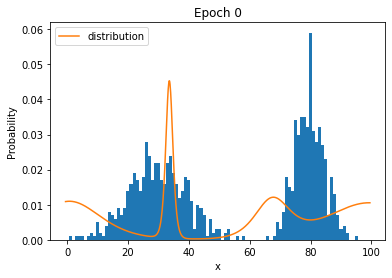

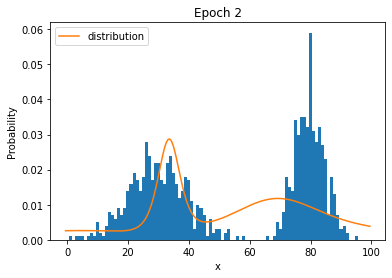

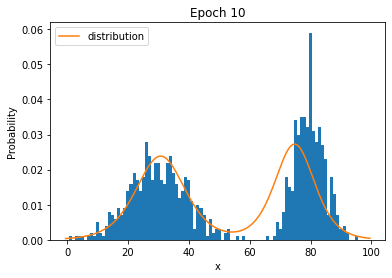

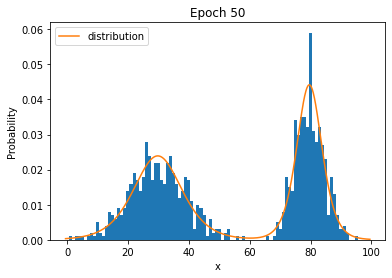

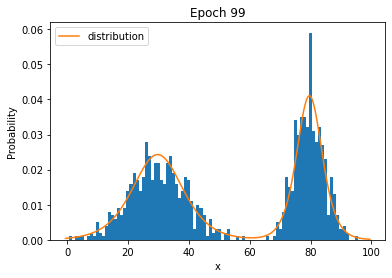

Test Loss 4.033889293670654


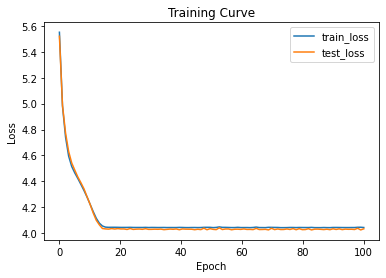

In [14]:
discretized = MixtureOfLogistics(d, n_mix=4)
train_epochs(discretized, train_loader, test_loader, dict(epochs=100, lr=1e-1))

# Demo 2: A Simple Autoregressive Model on 2D Data

In [15]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from deepul_helper.data import load_demo_2
from deepul_helper.utils import to_one_hot
from deepul_helper.visualize import plot_2d_dist, plot_train_curves

## ASD: 2D Data
Here 2D data is a series of 2-ary tuple (x0,x1). x0 represents the row and x1 represents the column. The images below are just 2D histograms. Do not confuse them as pixels. d defines the dimentionality of the data. Histogram needs to be of size (d,d). x0,x1 can both take values between [0,d] only.  

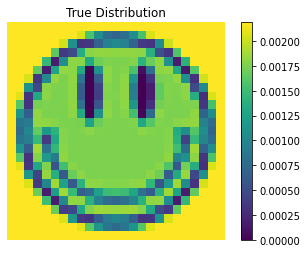

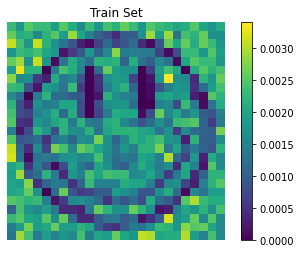

In [43]:
SEED = 1
np.random.seed(SEED)
torch.manual_seed(SEED)

device = torch.device('cuda')
n_train, n_test, d = 10000, 2500, 25
loader_args = dict(batch_size=128, shuffle=True)
train_loader, test_loader = load_demo_2(n_train, n_test, d, loader_args, visualize=True)

In [44]:
print (next(iter(train_loader)).shape)

torch.Size([128, 2])


In [45]:
btch = next(iter(train_loader))
print (btch.shape)
print (btch[:5])

torch.Size([128, 2])
tensor([[ 9.,  1.],
        [15., 17.],
        [17.,  1.],
        [ 3., 22.],
        [ 4., 13.]])


In [46]:
def train(model, train_loader, optimizer):
    model.train()
    train_losses = []
    for x in train_loader:
        x = x.to(device)
        loss = model.nll(x)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

    return np.mean(train_losses[-50:])

def eval_loss(model, data_loader):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for x in data_loader:
            x = x.to(device)
            loss = model.nll(x)
            total_loss += loss * x.shape[0]
        avg_loss = total_loss / len(data_loader.dataset)
    return avg_loss.item()

def train_epochs(model, train_loader, test_loader, train_args):
    epochs, lr = train_args['epochs'], train_args['lr']
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses, test_losses = [], []
    for epoch in range(epochs):
        train_loss = train(model, train_loader, optimizer)
        test_loss = eval_loss(model, test_loader)

        train_losses.append(train_loss)
        test_losses.append(test_loss)

        if epoch in [0, 2, 19, 49, 200]:
            plot_2d_dist(model.get_dist(), title=f'Epoch {epoch}, Learned Distribution')

    plot_2d_dist(model.get_dist())
    plot_train_curves(epochs, train_losses, test_losses, title='Training Curve')

## ASD: Autoregressive model
Here the distribution has been modeled as p(x0)*p(x1|x0). It could have been modeled direcly as histogram p(x0,x1). 

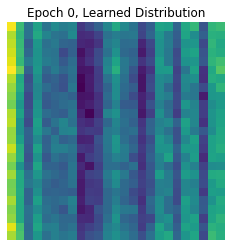

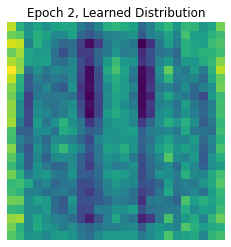

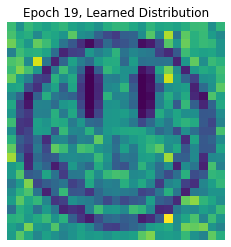

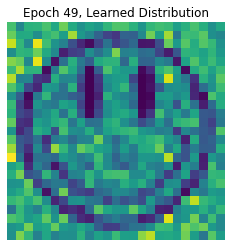

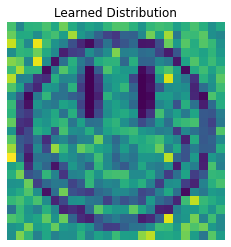

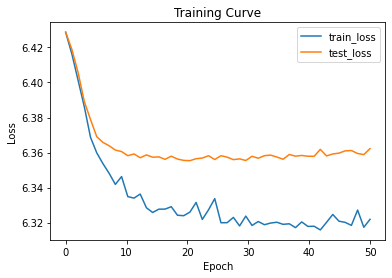

In [47]:
class SimpleAutoregModel(nn.Module):
    # Model p(x0)p(x1|x0), p(x0) as a histogram, p(x1|x0) as an MLP
    def __init__(self):
        super().__init__()
        self.logits_x0 = nn.Parameter(torch.zeros(d), requires_grad=True)
        self.cond_x1 = nn.Sequential(
            nn.Linear(d, 50),
            nn.ReLU(),
            nn.Linear(50, 50),
            nn.ReLU(),
            nn.Linear(50, d)
        )

    def nll(self, x):
        batch_size = x.shape[0]
        x0, x1 = x[:, 0], x[:, 1],

        # Loss for x0
        logits_x0 = self.logits_x0.unsqueeze(0).repeat(batch_size, 1)
        nll_x0 = F.cross_entropy(logits_x0, x0.long())

        # Loss for x1 | x0
        x0_onehot = to_one_hot(x0.long(), d, device) # use onehot as input
        logits_x1 = self.cond_x1(x0_onehot)
        nll_x1 = F.cross_entropy(logits_x1, x1.long())

        return nll_x0 + nll_x1
        #return nll_x0

    def get_dist(self):
        with torch.no_grad():
            x0 = torch.arange(d).to(device)
            x0 = to_one_hot(x0, d, device)

            prob_x0 = F.softmax(self.logits_x0, dim=0).unsqueeze(1)
            prob_x1 = F.softmax(self.cond_x1(x0), dim=1)
            prob = prob_x0 * prob_x1
            return prob.cpu().numpy()


model = SimpleAutoregModel().to(device)
train_epochs(model, train_loader, test_loader, dict(epochs=50, lr=1e-3))

# Demo 3 Different Autoregressive Model Architectures

In [ ]:
import numpy as np
import torch
import torch.nn as nn
from os.path import join
from deepul_helper.models import RNN, MADE, PixelCNN, WaveNet
from deepul_helper.visualize import visualize_batch

device = torch.device('cuda')
seed = 0
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

## RNN

In [ ]:
class RNN_Example(nn.Module):

    def __init__(self, device, append_loc=False, input_shape=(1, 28, 28), hidden_size=256):
        super().__init__()
        self.device = device
        self.append_loc = append_loc
        self.input_channels = input_shape[0] + 2 if append_loc else input_shape[0]
        self.hidden_size = hidden_size
        self.input_shape = input_shape
        self.canvas_size = input_shape[1] * input_shape[2]

        self.lstm = nn.LSTM(self.input_channels, self.hidden_size, num_layers=1, batch_first=True)
        self.fc = nn.Linear(self.hidden_size, input_shape[0])

    def nll(self, x):
        batch_size = x.shape[0]
        x_inp = append_location(x, self.device) if self.append_loc else x

        # Shift input by one to the right
        x_inp = x_inp.permute(0, 2, 3, 1).contiguous().view(batch_size, self.canvas_size, self.input_channels)
        x_inp = torch.cat((torch.zeros(batch_size, 1, self.input_channels).to(self.device), x_inp[:, :-1]), dim=1)

        h0 = torch.zeros(1, x_inp.size(0), self.hidden_size).to(self.device)
        c0 = torch.zeros(1, x_inp.size(0), self.hidden_size).to(self.device)

        # Forward propagate LSTM
        out, _ = self.lstm(x_inp, (h0, c0))  # out: tensor of shape (batch_size, seq_length, hidden_size)

        # Decode the hidden state of the last time step
        out = self.fc(out).squeeze(-1) # b x 784

        return F.binary_cross_entropy_with_logits(out, x.view(batch_size, -1))


    def sample(self, n):
        with torch.no_grad():
            samples = torch.zeros(n, 1, self.input_channels).to(self.device)
            h = torch.zeros(1, n, self.hidden_size).to(self.device)
            c = torch.zeros(1, n, self.hidden_size).to(self.device)

            for i in range(self.canvas_size):
                x_inp = samples[:, [i]]
                out, (h, c) = self.lstm(x_inp, (h, c))
                out = self.fc(out[:, 0, :])
                prob = torch.sigmoid(out)
                sample_pixel = torch.bernoulli(prob).unsqueeze(-1) # n x 1 x 1
                if self.append_loc:
                    loc = np.array([i // 28, i % 28]) / 27
                    loc = torch.FloatTensor(loc).to(self.device)
                    loc = loc.view(1, 1, 2).repeat(n, 1, 1)
                    sample_pixel = torch.cat((sample_pixel, loc), dim=-1)
                samples = torch.cat((samples, sample_pixel), dim=1)

            if self.append_loc:
                samples = samples[:, 1:, 0] # only get sampled pixels, ignore location
            else:
                samples = samples[:, 1:].squeeze(-1) # n x 784
            samples = samples.view(n, *self.input_shape)
            return samples.cpu()


In [ ]:
model = RNN(device, append_loc=False).to(device)
test_losses = np.load(join('pretrained_models', 'rnn', 'test_losses.npy'))
for epoch in [-1, 0, 1, 2, 8, 19]:
    model.load_state_dict(torch.load(join('pretrained_models', 'rnn', 'checkpoints', f'epoch{epoch}_state_dict')))
    samples = model.sample(64)
    if epoch == -1:
        visualize_batch(samples, title=f'Intialization')
    else:  
        print(f'Epoch {epoch} Test Loss: {test_losses[epoch] / np.log(2):.4f} bits/dim')
        visualize_batch(samples, title=f'Epoch {epoch}')

## RNN with Pixel Location Appended as Features

In [ ]:
model = RNN(device, append_loc=True).to(device)
test_losses = np.load(join('pretrained_models', 'rnn_loc', 'test_losses.npy'))
for epoch in [-1, 0, 1, 2, 8, 19]:
    model.load_state_dict(torch.load(join('pretrained_models', 'rnn_loc', 'checkpoints', f'epoch{epoch}_state_dict')))
    samples = model.sample(64)
    if epoch == -1:
        visualize_batch(samples, title=f'Intialization')
    else:  
        print(f'Epoch {epoch} Test Loss: {test_losses[epoch] / np.log(2):.4f} bits/dim')
        visualize_batch(samples, title=f'Epoch {epoch}')

## MADE

In [ ]:
class MaskedLinear(nn.Linear):
    """ same as Linear except has a configurable mask on the weights """

    def __init__(self, in_features, out_features, bias=True):
        super().__init__(in_features, out_features, bias)
        self.register_buffer('mask', torch.ones(out_features, in_features))

    def set_mask(self, mask):
        self.mask.data.copy_(torch.from_numpy(mask.astype(np.uint8).T))

    def forward(self, input):
        return F.linear(input, self.mask * self.weight, self.bias)


class MADE_Example(nn.Module):
    def __init__(self, device):
        super().__init__()
        self.nin = 784
        self.nout = 784
        self.hidden_sizes = [512, 512, 512]
        self.device = device

        # define a simple MLP neural net
        self.net = []
        hs = [self.nin] + self.hidden_sizes + [self.nout]
        for h0, h1 in zip(hs, hs[1:]):
            self.net.extend([
                MaskedLinear(h0, h1),
                nn.ReLU(),
            ])
        self.net.pop()  # pop the last ReLU for the output layer
        self.net = nn.Sequential(*self.net)

        self.m = {}
        self.create_mask()  # builds the initial self.m connectivity

    def create_mask(self):
        L = len(self.hidden_sizes)

        # sample the order of the inputs and the connectivity of all neurons
        self.m[-1] = np.arange(self.nin)
        for l in range(L):
            self.m[l] = np.random.randint(self.m[l - 1].min(), self.nin - 1, size=self.hidden_sizes[l])

        # construct the mask matrices
        masks = [self.m[l - 1][:, None] <= self.m[l][None, :] for l in range(L)]
        masks.append(self.m[L - 1][:, None] < self.m[-1][None, :])

        # set the masks in all MaskedLinear layers
        layers = [l for l in self.net.modules() if isinstance(l, MaskedLinear)]
        for l, m in zip(layers, masks):
            l.set_mask(m)

    def nll(self, x):
        x = x.view(-1, 784) # Flatten image
        logits = self.net(x)
        return F.binary_cross_entropy_with_logits(logits, x)

    def sample(self, n):
        samples = torch.zeros(n, 784).to(self.device)
        with torch.no_grad():
            for i in range(784):
                logits = self.net(samples)[:, i]
                probs = torch.sigmoid(logits)
                samples[:, i] = torch.bernoulli(probs)
            samples = samples.view(n, 1, 28, 28)
        return samples.cpu()

In [ ]:
model = MADE(device).to(device)
test_losses = np.load(join('pretrained_models', 'made_0', 'test_losses.npy'))
for epoch in [-1, 0, 1, 2, 8, 19]:
    model.load_state_dict(torch.load(join('pretrained_models', 'made_0', 'checkpoints', f'epoch{epoch}_state_dict')))
    samples = model.sample(64)
    if epoch == -1:
        visualize_batch(samples, title=f'Intialization')
    else:  
        print(f'Epoch {epoch} Test Loss: {test_losses[epoch] / np.log(2):.4f} bits/dim')
        visualize_batch(samples, title=f'Epoch {epoch}')

## WaveNet

In [ ]:
# Implementation pulled from https://github.com/ryujaehun/wavenet
# Type 'B' Conv
class DilatedCausalConv1d(nn.Module):
    """Dilated Causal Convolution for WaveNet"""
    def __init__(self, mask_type, in_channels, out_channels, dilation=1):
        super(DilatedCausalConv1d, self).__init__()
        self.conv = nn.Conv1d(in_channels, out_channels,
                              kernel_size=2, dilation=dilation, padding=0)
        self.dilation = dilation
        self.mask_type = mask_type
        assert mask_type in ['A', 'B']

    def forward(self, x):
        if self.mask_type == 'A':
            return self.conv(F.pad(x, [2, 0]))[:, :, :-1]
        else:
            return self.conv(F.pad(x, [self.dilation, 0]))


class ResidualBlock(nn.Module):
    def __init__(self, res_channels, dilation):
        super(ResidualBlock, self).__init__()

        self.dilated = DilatedCausalConv1d('B', res_channels, 2 * res_channels, dilation=dilation)
        self.conv_res = nn.Conv1d(res_channels, res_channels, 1)

    def forward(self, x):
        output = self.dilated(x)

        # PixelCNN gate
        o1, o2 = output.chunk(2, dim=1)
        output = torch.tanh(o1) * torch.sigmoid(o2)
        output = x + self.conv_res(output) # Residual network

        return output


class WaveNet_Example(nn.Module):
    def __init__(self, device):
        super(WaveNet, self).__init__()

        in_channels = 3
        out_channels = 1
        res_channels = 64
        layer_size = 9 # Largest dilation is 512
        stack_size = 1

        self.causal = DilatedCausalConv1d('A', in_channels, res_channels, dilation=1)
        self.res_stack = nn.Sequential(*[ResidualBlock(res_channels, 2 ** i)
                                         for i in range(layer_size)])
        self.out_conv = nn.Conv1d(res_channels, out_channels, 1)
        self.device = device

    def forward(self, x):
        batch_size = x.shape[0]
        x = append_location(x, self.device)
        output = x.view(batch_size, -1, 784)
        output = self.causal(output)
        output = self.res_stack(output)
        output = self.out_conv(output)
        return output.view(batch_size, 1, 28, 28)

    def nll(self, x):
        logits = self(x)
        return F.binary_cross_entropy_with_logits(logits, x)

    def sample(self, n):
        with torch.no_grad():
            samples = torch.zeros(n, 1, 28, 28).to(self.device)
            for r in range(28):
                for c in range(28):
                    logits = self(samples)[:, :, r, c]
                    probs = torch.sigmoid(logits)
                    samples[:, :, r, c] = torch.bernoulli(probs)
        return samples.cpu()

In [ ]:
model = WaveNet(device, append_loc=False).to(device)
test_losses = np.load(join('pretrained_models', 'wavenet', 'test_losses.npy'))
for epoch in [-1, 0, 1, 2, 8, 19]:
    model.load_state_dict(torch.load(join('pretrained_models', 'wavenet', 'checkpoints', f'epoch{epoch}_state_dict')))
    samples = model.sample(64)
    if epoch == -1:
        visualize_batch(samples, title=f'Intialization')
    else:  
        print(f'Epoch {epoch} Test Loss: {test_losses[epoch] / np.log(2):.4f} bits/dim')
        visualize_batch(samples, title=f'Epoch {epoch}')

## WaveNet with Pixel Location Appended as Features

In [ ]:
model = WaveNet(device, append_loc=True).to(device)
test_losses = np.load(join('pretrained_models', 'wavenet_loc', 'test_losses.npy'))
for epoch in [-1, 0, 1, 2, 8, 19]:
    model.load_state_dict(torch.load(join('pretrained_models', 'wavenet_loc', 'checkpoints', f'epoch{epoch}_state_dict')))
    samples = model.sample(64)
    if epoch == -1:
        visualize_batch(samples, title=f'Intialization')
    else:  
        print(f'Epoch {epoch} Test Loss: {test_losses[epoch] / np.log(2):.4f} bits/dim')
        visualize_batch(samples, title=f'Epoch {epoch}')

## PixelCNN

In [ ]:
class MaskConv2d(nn.Conv2d):
    def __init__(self, mask_type, *args, **kwargs):
        assert mask_type == 'A' or mask_type == 'B'
        super().__init__(*args, **kwargs)
        self.register_buffer('mask', torch.zeros_like(self.weight))
        self.create_mask(mask_type)

    def forward(self, input):
        return F.conv2d(input, self.weight * self.mask, self.bias, self.stride,
                        self.padding, self.dilation, self.groups)

    def create_mask(self, mask_type):
        k = self.kernel_size[0]
        self.mask[:, :, :k // 2] = 1
        self.mask[:, :, k // 2, :k // 2] = 1
        if mask_type == 'B':
            self.mask[:, :, k // 2, k // 2] = 1


class PixelCNN_Example(nn.Module):
    def __init__(self, device):
        super().__init__()
        model = [MaskConv2d('A', 1, 64, 7, padding=3), nn.ReLU()]
        for _ in range(3):
            model.extend([MaskConv2d('B', 64, 64, 7, padding=3), nn.ReLU()])
        model.append(MaskConv2d('B', 64, 1, 7,padding=3))
        self.net = nn.Sequential(*model)
        self.device = device

    def nll(self, x):
        logits = self.net(x)
        return F.binary_cross_entropy_with_logits(logits, x)

    def sample(self, n):
        samples = torch.zeros(n, 1, 28, 28).to(self.device)
        with torch.no_grad():
            for r in range(28):
                for c in range(28):
                    logits = self.net(samples)[:, :, r, c]
                    probs = torch.sigmoid(logits)
                    samples[:, :, r, c] = torch.bernoulli(probs)
        return samples.cpu()

In [ ]:
model = PixelCNN(device).to(device)
test_losses = np.load(join('pretrained_models', 'pixelcnn', 'test_losses.npy'))
for epoch in [-1, 0, 1, 2, 8, 19]:
    model.load_state_dict(torch.load(join('pretrained_models', 'pixelcnn', 'checkpoints', f'epoch{epoch}_state_dict')))
    samples = model.sample(64)
    if epoch == -1:
        visualize_batch(samples, title=f'Intialization')
    else:  
        print(f'Epoch {epoch} Test Loss: {test_losses[epoch] / np.log(2):.4f} bits/dim')
        visualize_batch(samples, title=f'Epoch {epoch}')

# Demo 4: Comparing Receptive Fields of PixelCNN and GatedPixelCNN (Blindspot)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn

from deepul_helper.models import MaskConv2d

seed = 0
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

In [ ]:
class PixelCNN(nn.Module):
    name = 'PixelCNN'
    def __init__(self, n_layers):
        super().__init__()
        model = [MaskConv2d('A', 1, 1, 3, padding=1)]
        for _ in range(n_layers - 2):
            model.extend([MaskConv2d('B', 1, 1, 3, padding=1)])
        model.append(MaskConv2d('B', 1, 1, 3,padding=1))
        self.net = nn.Sequential(*model)

    def forward(self, x):
        return self.net(x)

In [ ]:
class HoriVertStackConv2d(nn.Module):
    def __init__(self, mask_type, in_channels, out_channels, k=3, padding=1):
        super().__init__()
        self.vertical = nn.Conv2d(in_channels, out_channels, kernel_size=k,
                                  padding=padding, bias=False)
        self.horizontal = nn.Conv2d(in_channels, out_channels, kernel_size=(1, k),
                                    padding=(0, padding), bias=False)
        self.vtohori = nn.Conv2d(out_channels, out_channels, kernel_size=1, bias=False)

        self.register_buffer('vmask', self.vertical.weight.data.clone())
        self.register_buffer('hmask', self.horizontal.weight.data.clone())

        self.vmask.fill_(1)
        self.hmask.fill_(1)

        # zero the bottom half rows of the vmask
        self.vmask[:, :, k // 2 + 1:, :] = 0

        # zero the right half of the hmask
        self.hmask[:, :, :, k // 2 + 1:] = 0
        if mask_type == 'A':
            self.hmask[:, :, :, k // 2] = 0

    def down_shift(self, x):
        x = x[:, :, :-1, :]
        pad = nn.ZeroPad2d((0, 0, 1, 0))
        return pad(x)

    def forward(self, x):
        vx, hx = x.chunk(2, dim=1)

        self.vertical.weight.data *= self.vmask
        self.horizontal.weight.data *= self.hmask

        vx = self.vertical(vx)
        hx = self.horizontal(hx)
        # Allow horizontal stack to see information from vertical stack
        hx = hx + self.vtohori(self.down_shift(vx))

        return torch.cat((vx, hx), dim=1)

# PixelCNN using horizontal and vertical stacks to fix blind-spot
class HoriVertStackPixelCNN(nn.Module):
    name = 'HoriVertStackPixelCNN'
    def __init__(self, n_layers):
        super().__init__()
        model = [HoriVertStackConv2d('A', 1, 1, 3, padding=1)]
        for _ in range(n_layers - 2):
            model.extend([HoriVertStackConv2d('B', 1, 1, 3, padding=1)])
        model.append(HoriVertStackConv2d('B', 1, 1, 3, padding=1))
        self.net = nn.Sequential(*model)

    def forward(self, x):
        return self.net(torch.cat((x, x), dim=1)).chunk(2, dim=1)[1]

In [ ]:
def plot_receptive_field(model, data):
    out = model(data)
    out[0, 0, 5, 5].backward()
    grad = data.grad.detach().cpu().numpy()[0, 0]
    grad = np.abs(grad)
    grad = (grad > 1e-8).astype('float32')
    grad[5, 5] = 0.5

    plt.figure()
    plt.imshow(grad)
    plt.title(f'Receptive field from pixel (5, 5), {model.name} {n_layers} layers')
    plt.show()

In [ ]:
x = torch.randn(1, 1, 10, 10).cuda()
x.requires_grad = True

## PixelCNN Blindspot

In [ ]:
for i, n_layers in enumerate([2, 3, 5]):
    pixelcnn = PixelCNN(n_layers=n_layers).cuda()
    plot_receptive_field(pixelcnn, x)
    x.grad.zero_()

## PixelCNN with Horizontal and Vertical Stacked Convolutions (No Blindspot)

In [ ]:
for i, n_layers in enumerate([2,3, 5]):
    gated_pixelcnn = HoriVertStackPixelCNN(n_layers=n_layers).cuda()
    plot_receptive_field(gated_pixelcnn, x)
    x.grad.zero_()

# Demo 5: Self-Attention Autoregressive Model

In [ ]:
import torch.nn as nn
import torch
from os.path import join
import numpy as np
from deepul_helper.models import Transformer
from deepul_helper.visualize import visualize_batch

## Multi-Head Attention Module (Key Component in Self-Attention)
Only learns well with pixel locations appended as features (as opposed to no appended features and positional encodings)

In [ ]:
class MultiHeadAttention(nn.Module):
    ''' Multi-Head Attention module '''

    def __init__(self, n_head, d_model, d_k, d_v, dropout=0.1):
        super().__init__()

        self.n_head = n_head
        self.d_k = d_k
        self.d_v = d_v

        self.w_qs = nn.Linear(d_model, n_head * d_k, bias=False)
        self.w_ks = nn.Linear(d_model, n_head * d_k, bias=False)
        self.w_vs = nn.Linear(d_model, n_head * d_v, bias=False)
        self.fc = nn.Linear(n_head * d_v, d_model, bias=False)

        self.attention = ScaledDotProductAttention(temperature=d_k ** 0.5)

        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(d_model, eps=1e-6)

    def forward(self, q, k, v, mask=None):
        d_k, d_v, n_head = self.d_k, self.d_v, self.n_head
        sz_b, len_q, len_k, len_v = q.size(0), q.size(1), k.size(1), v.size(1)

        residual = q
        q = self.layer_norm(q)

        # Pass through the pre-attention projection: b x lq x (n*dv)
        # Separate different heads: b x lq x n x dv
        q = self.w_qs(q).view(sz_b, len_q, n_head, d_k)
        k = self.w_ks(k).view(sz_b, len_k, n_head, d_k)
        v = self.w_vs(v).view(sz_b, len_v, n_head, d_v)

        # Transpose for attention dot product: b x n x lq x dv
        q, k, v = q.transpose(1, 2), k.transpose(1, 2), v.transpose(1, 2)

        if mask is not None:
            mask = mask.unsqueeze(0).unsqueeze(0)  # For head axis broadcasting.

        q, attn = self.attention(q, k, v, mask=mask)

        # Transpose to move the head dimension back: b x lq x n x dv
        # Combine the last two dimensions to concatenate all the heads together: b x lq x (n*dv)
        q = q.transpose(1, 2).contiguous().view(sz_b, len_q, -1)
        q = self.dropout(self.fc(q))
        q += residual

        return q

In [ ]:
device = torch.device('cuda')
model = Transformer(device, mode='pixel_location').to(device)
test_losses = np.load(join('pretrained_models', 'transformer_loc', 'test_losses.npy'))
for epoch in [-1, 0, 1, 2, 8, 19]:
    model.load_state_dict(torch.load(join('pretrained_models', 'transformer_loc', 'checkpoints', f'epoch{epoch}_state_dict')))
    samples = model.sample(64)
    if epoch == -1:
        visualize_batch(samples, title=f'Intialization')
    else:  
        print(f'Epoch {epoch} Test Loss: {test_losses[epoch] / np.log(2):.4f} bits/dim')
        visualize_batch(samples, title=f'Epoch {epoch}')

# Demo 6: Different Autoregressive Orderings

Here, we experiment with different autoregressive ordering with MADE on MNIST

In [ ]:
from os.path import join
import numpy as np
import torch

from deepul_helper.models import MADE
from deepul_helper.visualize import visualize_batch

device = torch.device('cuda')

In [ ]:
def run_demo(ordering, order_id):
    model = MADE(device, ordering=ordering).to(device)
    model.load_state_dict(torch.load(join('pretrained_models', f'made_{order_id}', 'checkpoints', f'epoch19_state_dict')))
    test_losses = np.load(join('pretrained_models', f'made_{order_id}', 'test_losses.npy'))
    samples = model.sample(64)
    print('Test Loss', test_losses[-1])
    visualize_batch(samples, title=f'Samples')

## Order 1: Random Permutation

In [ ]:
ordering = np.random.permutation(784)
run_demo(ordering, order_id=1)

## Order 2: Even Indices Then Odd Indices

In [ ]:
ordering = np.concatenate((np.arange(0, 784, 2), np.arange(1, 784, 2)))
run_demo(ordering, order_id=2)

## Order 3: Rows (Raster Scan)

In [ ]:
ordering = np.arange(784)
run_demo(ordering, order_id=0)

## Order 4: Columns

In [ ]:
ordering = np.arange(784).reshape(28, 28).T.reshape(-1)
run_demo(ordering, order_id=3)

## Order 4: Top to Middle then Bottom to Middle

In [ ]:
ordering = np.concatenate((np.arange(784 // 2), np.arange(784 // 2, 784)[::-1]))
run_demo(ordering, order_id=4)

# Demo 7: Conditional Autoregressive Models

In [ ]:
from os.path import join
import torch
import torch.nn as nn
import torch.nn.functional as F
from deepul_helper.visualize import visualize_batch
from deepul_helper.utils import to_one_hot
from deepul_helper.models import PixelCNN

device = torch.device('cuda')

In [ ]:
class MaskConv2d(nn.Conv2d):
    def __init__(self, mask_type, *args, conditional_size=None, **kwargs):
        assert mask_type == 'A' or mask_type == 'B'
        super().__init__(*args, **kwargs)
        self.register_buffer('mask', torch.zeros_like(self.weight))
        self.create_mask(mask_type)
        self.conditional_size = conditional_size
        if self.conditional_size:
            if len(conditional_size) == 1:
                self.cond_op = nn.Linear(conditional_size[0], self.out_channels)
            elif len(conditional_size) == 3:
                self.cond_op = nn.Conv2d(conditional_size[0], self.out_channels,
                                         kernel_size=3, padding=1)
            else:
                raise Exception('Invalid conditional_size', conditional_size)

    def forward(self, input, cond=None):
        batch_size = input.shape[0]
        out = F.conv2d(input, self.weight * self.mask, self.bias, self.stride,
                       self.padding, self.dilation, self.groups)
        if self.conditional_size:
            if len(self.conditional_size) == 1:
                # Broadcast across height and width of image and add as conditional bias
                out = out + self.cond_op(cond).view(batch_size, -1, 1, 1)
            elif len(self.conditional_size) == 3:
                out = out + self.cond_op(cond)
            else:
                raise Exception()
        return out

    def create_mask(self, mask_type):
        k = self.kernel_size[0]
        self.mask[:, :, :k // 2] = 1
        self.mask[:, :, k // 2, :k // 2] = 1
        if mask_type == 'B':
            self.mask[:, :, k // 2, k // 2] = 1

class ConditionalPixelCNN_Example(nn.Module):
    # If conditional_size is None, then the model is not conditional
    def __init__(self, device, conditional_size=None):
        super().__init__()
        assert conditional_size is None or isinstance(conditional_size, tuple)
        if conditional_size is not None:
            # 1D conditional (e.g. one-hot vectors for class-conditional)
            if len(conditional_size) == 1:
                self.cond_op = lambda x: x # Identity
            # 3D conditional (e.g. subsampled image when performing super-resolution)
            elif len(conditional_size) == 3:
                # First upsample the image we are conditioning on to fit the MNIST image size
                # We assume we are conditioning on 1 x 7 x 7 MNIST images
                self.cond_op = nn.Sequential(
                    nn.Conv2d(conditional_size[0], 64, 3, padding=1),
                    nn.ReLU(),
                    nn.Upsample(scale_factor=2),
                    nn.Conv2d(64, 64, 3, padding=1),
                    nn.ReLU(),
                    nn.Upsample(scale_factor=2),
                    nn.Conv2d(64, 64, 3, padding=1),
                    nn.ReLU()
                )
                conditional_size = (64, 28, 28)

        model = nn.ModuleList([MaskConv2d('A', 1, 64, 7, padding=3, conditional_size=conditional_size), nn.ReLU()])
        for _ in range(3):
            model.extend([MaskConv2d('B', 64, 64, 7, padding=3, conditional_size=conditional_size), nn.ReLU()])
        model.append(MaskConv2d('B', 64, 1, 7,padding=3, conditional_size=conditional_size))
        self.net = model
        self.device = device

    def forward(self, x, cond=None):
        if cond is not None:
            cond = self.cond_op(cond)
        out = x
        for layer in self.net:
            if isinstance(layer, MaskConv2d):
                out = layer(out, cond=cond)
            else:
                out = layer(out)
        return out

    def nll(self, x, cond=None):
        return F.binary_cross_entropy_with_logits(self(x, cond=cond), x)

    def sample(self, n, cond=None):
        samples = torch.zeros(n, 1, 28, 28).to(self.device)
        with torch.no_grad():
            for r in range(28):
                for c in range(28):
                    logits = self(samples, cond=cond)[:, :, r, c]
                    probs = torch.sigmoid(logits)
                    samples[:, :, r, c] = torch.bernoulli(probs)
        return samples.cpu()

## Class-Conditional PixelCNN
We condition on one-hot label of MNIST classes


In [ ]:
model = PixelCNN(device, conditional_size=(10,), n_layers=5).to(device)
model.load_state_dict(torch.load(join('pretrained_models', 'pixelcnn_class', 'checkpoints', 'epoch9_state_dict')))

cond = torch.arange(10).unsqueeze(1).repeat(1, 10).view(-1).to(device)
cond = to_one_hot(cond, 10, device)
samples = model.sample(100, cond=cond)
visualize_batch(samples, nrow=10, figsize=(10, 10))

## Image Super-Resolution with a PixelCNN
We condition on subsampled-version of MNIST images. Note that we show the subsampled image in an enlarged form for easier viewing.

In [ ]:
model = PixelCNN(device, conditional_size=(1, 7, 7), n_layers=5).to(device)
model.load_state_dict(torch.load(join('pretrained_models', 'pixelcnn_image', 'checkpoints', 'epoch9_state_dict')))

_, test_loader = load_data()
x = next(iter(test_loader))[0][:32]
cond = F.interpolate(x, scale_factor=0.25, mode='bilinear').to(device)
samples = model.sample(32, cond=cond)
cond = F.interpolate(cond, scale_factor=4).cpu()
images = torch.stack((cond, samples), dim=1)
images = images.view(-1, *images.shape[2:])
visualize_batch(images, nrow=8, figsize=(10, 10))

# Demo 8: Hierarchy (Grayscale PixelCNNs)

In [ ]:
from os.path import join
import torch
from deepul_helper.models import GrayscalePixelCNN
from deepul_helper.visualize import visualize_batch


class GrayscalePixelCNN_Example(nn.Module):

    def __init__(self, device):
        super().__init__()
        self.input_size = (3, 28, 28) # Colored MNIST
        self.device = device

        self.grayscale_prior = PixelCNN(device, n_layers=8, n_channels=1,
                                        n_color_bits=2, conditional=False)
        self.color_conditional = PixelCNN(device, n_layers=8, n_channels=3,
                                          n_color_bits=2, conditional=True)

    def nll(self, x):
        x_gray = quantize(to_grayscale(x), 1) # convert to grayscale and quantize to 1 bits
        x_color = quantize(x, 2) # quantize to 2 bits

        nll_gray = self.grayscale_prior.nll(x_gray)
        nll_color = self.color_conditional.nll(x_color, cond=x_gray)

        return nll_gray + nll_color

    def sample(self, n):
        gray_samples = self.grayscale_prior.sample(n)
        color_samples = self.color_conditional.sample(n, cond=gray_samples.to(self.device))
        return gray_samples, color_samples

In [ ]:
device = torch.device('cuda')
model = GrayscalePixelCNN(device).cuda()
model.load_state_dict(torch.load(join('pretrained_models', 'grayscale_pixelcnn', 'checkpoints', 'epoch17_state_dict')))

gray_samples, color_samples = model.sample(32)
gray_samples = gray_samples.repeat(1, 3, 1, 1)
samples = torch.stack((gray_samples, color_samples), dim=1).view(-1, 3, 28, 28)
visualize_batch(samples, figsize=(10, 10))

# Demo 9: Fast Sampling (Parallel PixelCNNs)
In this demo we model 224 x 224 MNIST images. A standard PixelCNN would need 224 * 224 = 50176 network evaluations, but a Parallel PixelCNN upscaling with a base size of 7 x 7 to 224 x 224 would only need 7 * 7 + 3 + 3 + 3 + 3 + 3 = 64 network evaluations

In [ ]:
from os.path import join
import torch
import torch.nn as nn
import torch.nn.functional as F
from deepul_helper.models import ParallelPixelCNN
from deepul_helper.visualize import visualize_batch

class CNN(nn.Module):

    def __init__(self, in_channels, out_channels, n_layers, filter_size=64, kernel_size=3):
        super().__init__()
        model = []
        h_prev = in_channels
        for h in [filter_size] * (n_layers - 1) + [out_channels]:
            model.append(nn.Conv2d(h_prev, h, kernel_size=kernel_size, padding=kernel_size // 2))
            model.append(nn.ReLU())
            h_prev = h
        model.pop()
        self.net = nn.Sequential(*model)

    def forward(self, x):
        return self.net(x)



class ParallelPixelCNN_Example(nn.Module):

    def __init__(self, device):
        super().__init__()
        self.device = device
        self.base_pixelcnn = PixelCNN(device, input_shape=(1, 7, 7), kernel_size=3, n_layers=7)
        self.group_nets = nn.ModuleList([CNN(1, 1, 4, kernel_size=7),
                                         CNN(2, 1, 4, kernel_size=7),
                                         CNN(3, 1, 4, kernel_size=7)])

        self.base_size = 7
        self.input_shape = (1, 224, 224)

    def nll(self, x):
        nll = 0
        n_scale_iter = int(np.log2(x.shape[2] // self.base_size))
        for i in range(n_scale_iter):
            stride = 2 ** (n_scale_iter - i)
            offset = stride // 2
            current_x = x[:, :, ::stride, ::stride] # Top-left group 1
            if i == 0:
                nll = nll + self.base_pixelcnn.nll(current_x)

            for j in range(3):
                if j == 0:
                    target = x[:, :, ::stride, offset::stride] # Top-right group 2
                elif j == 1:
                    target = x[:, :, offset::stride, ::stride] # Bottom-left group 3
                else:
                    target = x[:, :, offset::stride, offset::stride] # Bottom-right group 4
                logits = self.group_nets[j](current_x)
                nll = nll + F.binary_cross_entropy_with_logits(logits, target)
                current_x = torch.cat((current_x, target), dim=1)
        return nll


    def sample(self, n):
        with torch.no_grad():
            samples = torch.zeros(n, *self.input_shape).to(self.device)
            n_scale_iter = int(np.log2(samples.shape[2] // self.base_size))
            for i in range(n_scale_iter):
                stride = 2 ** (n_scale_iter - i)
                offset = stride // 2
                if i == 0:
                    samples[:, :, ::stride, ::stride] = self.base_pixelcnn.sample(n)

                current_input = samples[:, :, ::stride, ::stride]
                for j in range(3):
                    logits = self.group_nets[j](current_input)
                    probs = torch.sigmoid(logits)
                    s = torch.bernoulli(probs)
                    current_input = torch.cat((current_input, s), dim=1)

                    if j == 0:
                        samples[:, :, ::stride, offset::stride] = s
                    elif j == 1:
                        samples[:, :, offset::stride, ::stride] = s
                    else:
                        samples[:, :, offset::stride, offset::stride] = s
            return samples.cpu()

In [ ]:
def expand_subsampled(samples):
    images = []
    for i in range(5):
        stride = 2 ** (5 - i)
        img = samples[:, :, ::stride, ::stride]
        img = F.interpolate(img, size=(224, 224))
        images.append(img)
    images.append(samples)
    images = torch.stack(images, dim=1).view(-1, 1, 224, 224)
    return images

device = torch.device('cuda')
model = ParallelPixelCNN(device).to(device)
model.load_state_dict(torch.load(join('pretrained_models', 'parallel_pixelcnn', 'checkpoints', 'epoch15_state_dict')))
samples = model.sample(10)
images = expand_subsampled(samples)
visualize_batch(images, nrow=6, figsize=(10, 10))